In [17]:
import math
import itertools
import warnings
import os, datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from tensorflow import keras
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.preprocessing import TransactionEncoder
from tensorflow.keras import layers


#df = pd.read_csv("Global_Mobile_Prices_2025_Extended.csv")'
df = pd.read_csv("shop.csv")
df1 = pd.read_csv("shop.csv")
print("Размер данных")
print(df.shape)
print("Информация")
print(df.info())


Размер данных
(3900, 16)
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Discount Applied        3900 non-null   object 
 13  Previous Purchases      3900 non-null   int64  
 14  Paym

In [18]:
print("Строки")
print(df.head(10))

Строки
   Customer ID  Age Gender Item Purchased     Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse     Clothing                     53   
1            2   19   Male        Sweater     Clothing                     64   
2            3   50   Male          Jeans     Clothing                     73   
3            4   21   Male        Sandals     Footwear                     90   
4            5   45   Male         Blouse     Clothing                     49   
5            6   46   Male       Sneakers     Footwear                     20   
6            7   63   Male          Shirt     Clothing                     85   
7            8   27   Male         Shorts     Clothing                     34   
8            9   26   Male           Coat    Outerwear                     97   
9           10   57   Male        Handbag  Accessories                     31   

        Location Size      Color  Season  Review Rating Subscription Status  \
0       Kentucky    L 

In [19]:
print("Пропущенные значения по столбцам:")
print(df.isna().sum())

Пропущенные значения по столбцам:
Customer ID               0
Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Size                      0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Discount Applied          0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
dtype: int64


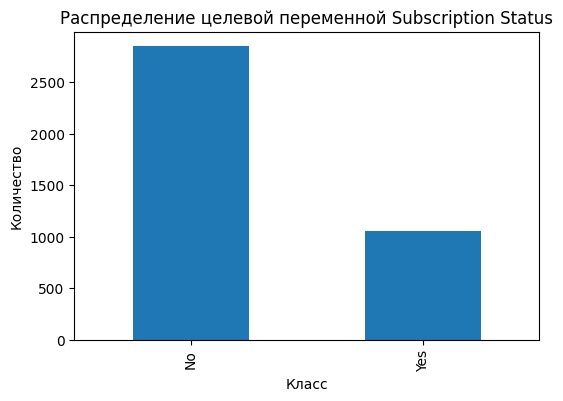

In [20]:
# ==== 2. Распределение целевой переменной ====
plt.figure(figsize=(6,4))
df['Subscription Status'].value_counts().plot(kind='bar')
#df['5g_support'].value_counts().plot(kind='bar')
plt.title("Распределение целевой переменной Subscription Status")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()

In [21]:
# 1.3 Преобразуем целевую в числа 
df['target'] = df['Subscription Status'].map(lambda x: 1 if str(x).lower() in ['yes', 'true', '1', 'y'] else 0)
#df['target'] = df['5g_support'].map(lambda x: 1 if str(x).lower() in ['yes', 'true', '1', 'y'] else 0)
print(df['target'].value_counts(normalize=True))

target
0    0.73
1    0.27
Name: proportion, dtype: float64


In [22]:
 #Разделение признаков на числовые / категориальные
num_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
cat_cols = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 
           'Color', 'Season', 'Discount Applied', 'Payment Method', 'Frequency of Purchases']

#num_cols = ['price_usd', 'ram_gb', 'storage_gb', 'camera_mp',
#            'battery_mah', 'display_size_inch', 'charging_watt', 'rating', 'year']
#cat_cols = ['brand', 'os', 'processor', 'release_month']  # 5g_support убрали — целевая
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], sparse_threshold=0)


X = df[num_cols + cat_cols]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("X_train_proc shape:", X_train_proc.shape)
print("X_test_proc shape:", X_test_proc.shape)

X_train_proc shape: (3120, 123)
X_test_proc shape: (780, 123)


In [23]:
def evaluate_model(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}

# 3.2 Logistic Regression baseline (pipeline: preprocessor + model)

pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, random_state=42))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
y_proba = pipe_lr.predict_proba(X_test)[:,1]

print("Baseline LogisticRegression:", evaluate_model(y_test, y_pred, y_proba))
print("Accuracy: 85.1% - модель правильно предсказывает статус подписки в 85% случаев")
print("Более низкий precision: 0,67% - означает, что есть некоторое количество ложных срабатываний - модель иногда ошибочно предсказывает подписку")
print("Высокий recall говорит, что модель эффективно находит большинство подписчиков")
print("F1-score: 75.7% - хороший баланс между precision и recall")
print("AUC 0.91 указывает на высокую предсказательную способность")

Baseline LogisticRegression: {'accuracy': 0.8512820512820513, 'precision': 0.6779026217228464, 'recall': 0.8578199052132701, 'f1': 0.7573221757322176, 'auc': 0.9096027786338384}
Accuracy: 85.1% - модель правильно предсказывает статус подписки в 85% случаев
Более низкий precision: 0,67% - означает, что есть некоторое количество ложных срабатываний - модель иногда ошибочно предсказывает подписку
Высокий recall говорит, что модель эффективно находит большинство подписчиков
F1-score: 75.7% - хороший баланс между precision и recall
AUC 0.91 указывает на высокую предсказательную способность


In [24]:
results = {}

# ===== 1. GaussianNB =====
pipe_gnb = make_pipeline(preprocessor, GaussianNB())
pipe_gnb.fit(X_train, y_train)
pred = pipe_gnb.predict(X_test)
proba = pipe_gnb.predict_proba(X_test)[:,1]
results["GaussianNB"] = evaluate_model(y_test, pred, proba)

# ===== 2. BernoulliNB =====
pipe_bnb = make_pipeline(preprocessor, BernoulliNB())
pipe_bnb.fit(X_train, y_train)
pred = pipe_bnb.predict(X_test)
proba = pipe_bnb.predict_proba(X_test)[:,1]
results["BernoulliNB"] = evaluate_model(y_test, pred, proba)

# ===== 3. MultinomialNB (только положительные признаки) =====
categorical_transformer_no_scale = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor_no_scale = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    ('cat', categorical_transformer_no_scale, cat_cols)
], sparse_threshold=0)

pipe_mnb = make_pipeline(preprocessor_no_scale, MultinomialNB())
pipe_mnb.fit(X_train, y_train)

pred = pipe_mnb.predict(X_test)
proba = pipe_mnb.predict_proba(X_test)[:,1]
results["MultinomialNB"] = evaluate_model(y_test, pred, proba)

# ===== 4. ComplementNB =====
categorical_transformer_no_scale2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor_no_scale2 = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    ('cat', categorical_transformer_no_scale2, cat_cols)
], sparse_threshold=0)

pipe_cnb = make_pipeline(preprocessor_no_scale2, ComplementNB())
pipe_cnb.fit(X_train, y_train)
pred = pipe_cnb.predict(X_test)
proba = pipe_cnb.predict_proba(X_test)[:,1]
results["ComplementNB"] = evaluate_model(y_test, pred, proba)

# ===== 5. Decision Tree =====
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42))
pipe_dt.fit(X_train, y_train)
pred = pipe_dt.predict(X_test)
proba = pipe_dt.predict_proba(X_test)[:,1]
results["DecisionTree"] = evaluate_model(y_test, pred, proba)

# ===== 6. LDA =====
pipe_lda = make_pipeline(preprocessor, LinearDiscriminantAnalysis())
pipe_lda.fit(X_train, y_train)
pred = pipe_lda.predict(X_test)
proba = pipe_lda.predict_proba(X_test)[:,1]
results["LDA"] = evaluate_model(y_test, pred, proba)

# ===== 7. SVM (нужны вероятности) =====
pipe_svm = make_pipeline(preprocessor, SVC(probability=True, random_state=42))
pipe_svm.fit(X_train, y_train)
pred = pipe_svm.predict(X_test)
proba = pipe_svm.predict_proba(X_test)[:,1]
results["SVM"] = evaluate_model(y_test, pred, proba)

# ===== 8. kNN =====
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=5))
pipe_knn.fit(X_train, y_train)
pred = pipe_knn.predict(X_test)
proba = pipe_knn.predict_proba(X_test)[:,1]
results["kNN"] = evaluate_model(y_test, pred, proba)

# ===== Таблица результатов =====
df_results = pd.DataFrame(results).T
print(df_results)

print("Лучшие модели:")
print("LDA, GaussianNB и BernoulliNB демонстрируют схожую эффективность с accuracy около 86% и высоким recall (~98%), что означает они отлично находят почти всех")
print("подписчиков, но с некоторым количеством ложных срабатываний")
print("Средние результаты:")
print("SVM показывает сопоставимые результаты, Decision Tree - умеренные.")
print("Худшие показатели:")
print("Все модели кроме MultinomialNB и ComplementNB показывают очень высокий recall при умеренном precision - это говорит о том, что признаки в данных хорошо")
print("разделяют классы, но есть пространство для оптимизации баланса между обнаружением подписчиков и минимизацией ложных срабатываний.")

               accuracy  precision    recall        f1       auc
GaussianNB     0.858974   0.663430  0.971564  0.788462  0.911585
BernoulliNB    0.860256   0.663462  0.981043  0.791587  0.911010
MultinomialNB  0.766667   0.597315  0.421801  0.494444  0.805471
ComplementNB   0.719231   0.488095  0.777251  0.599634  0.805471
DecisionTree   0.820513   0.674877  0.649289  0.661836  0.766648
LDA            0.864103   0.668810  0.985782  0.796935  0.908462
SVM            0.862821   0.667742  0.981043  0.794626  0.905488
kNN            0.778205   0.623377  0.454976  0.526027  0.817182
Лучшие модели:
LDA, GaussianNB и BernoulliNB демонстрируют схожую эффективность с accuracy около 86% и высоким recall (~98%), что означает они отлично находят почти всех
подписчиков, но с некоторым количеством ложных срабатываний
Средние результаты:
SVM показывает сопоставимые результаты, Decision Tree - умеренные.
Худшие показатели:
Все модели кроме MultinomialNB и ComplementNB показывают очень высокий recall п

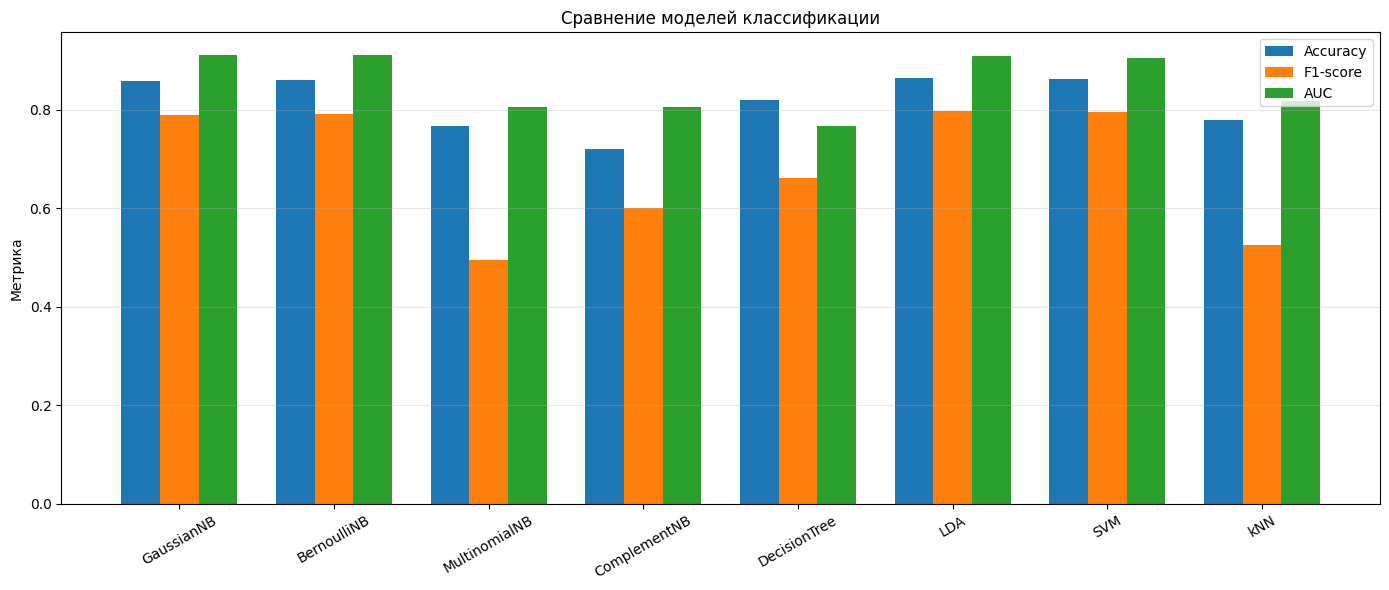

In [25]:
models = list(results.keys())
accuracy = [results[m]["accuracy"] for m in models]
f1 =       [results[m]["f1"]       for m in models]
auc =      [results[m]["auc"]      for m in models]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, accuracy, width, label='Accuracy')
plt.bar(x,         f1,       width, label='F1-score')
plt.bar(x + width, auc,      width, label='AUC')

plt.xticks(x, models, rotation=30)
plt.ylabel("Метрика")
plt.title("Сравнение моделей классификации")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:

results_tuned = {}
warnings.filterwarnings('ignore')  # убираем предупреждения

# ==================================================
# 1. GaussianNB — параметров почти нет, просто оставляем
# ==================================================
pipe_gnb = make_pipeline(preprocessor, GaussianNB())
pipe_gnb.fit(X_train, y_train)
pred = pipe_gnb.predict(X_test)
proba = pipe_gnb.predict_proba(X_test)[:,1]
results_tuned["GaussianNB"] = evaluate_model(y_test, pred, proba)

# ==================================================
# 2. BernoulliNB (alpha)
# ==================================================
param_bnb = {
    "bernoullinb__alpha": [0.1, 0.5, 1.0, 2.0]
}

pipe_bnb = make_pipeline(preprocessor, BernoulliNB())
grid_bnb = GridSearchCV(pipe_bnb, param_bnb, cv=5, scoring="f1", n_jobs=-1)
grid_bnb.fit(X_train, y_train)

pred = grid_bnb.predict(X_test)
proba = grid_bnb.predict_proba(X_test)[:,1]
results_tuned["BernoulliNB"] = evaluate_model(y_test, pred, proba)

print("BernoulliNB best params:", grid_bnb.best_params_)

# ==================================================
# 3. MultinomialNB (only positive features)
# ==================================================
preprocessor_pos = ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols)
], sparse_threshold=0)

pipe_mnb = make_pipeline(preprocessor_pos, MultinomialNB())

param_mnb = {
    "multinomialnb__alpha": [0.1, 0.5, 1.0, 2.0]
}

grid_mnb = GridSearchCV(pipe_mnb, param_mnb, cv=5, scoring="f1", n_jobs=-1)
grid_mnb.fit(X_train, y_train)

pred = grid_mnb.predict(X_test)
proba = grid_mnb.predict_proba(X_test)[:,1]
results_tuned["MultinomialNB"] = evaluate_model(y_test, pred, proba)

print("MultinomialNB best params:", grid_mnb.best_params_)

# ==================================================
# 4. ComplementNB (alpha)
# ==================================================
pipe_cnb = make_pipeline(preprocessor_pos, ComplementNB())

param_cnb = {
    "complementnb__alpha": [0.1, 0.5, 1.0, 2.0]
}

grid_cnb = GridSearchCV(pipe_cnb, param_cnb, cv=5, scoring="f1", n_jobs=-1)
grid_cnb.fit(X_train, y_train)

pred = grid_cnb.predict(X_test)
proba = grid_cnb.predict_proba(X_test)[:,1]
results_tuned["ComplementNB"] = evaluate_model(y_test, pred, proba)

print("ComplementNB best params:", grid_cnb.best_params_)

# ==================================================
# 5. Decision Tree
# ==================================================
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42))

param_dt = {
    "decisiontreeclassifier__max_depth": [3, 5, 7, 10, 15, None],
    "decisiontreeclassifier__min_samples_split": [2, 5, 10],
    "decisiontreeclassifier__criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(pipe_dt, param_dt, cv=5, scoring="f1", n_jobs=-1)
grid_dt.fit(X_train, y_train)

pred = grid_dt.predict(X_test)
proba = grid_dt.predict_proba(X_test)[:,1]
results_tuned["DecisionTree"] = evaluate_model(y_test, pred, proba)

print("DecisionTree best params:", grid_dt.best_params_)

# ==================================================
# 6. LDA
# ==================================================
pipe_lda = make_pipeline(preprocessor, LinearDiscriminantAnalysis())

param_lda = {
    "lineardiscriminantanalysis__solver": ["svd", "lsqr"],
    "lineardiscriminantanalysis__shrinkage": [None, "auto"]  # работает только при lsqr
}

grid_lda = GridSearchCV(pipe_lda, param_lda, cv=5, scoring="f1", n_jobs=-1)
grid_lda.fit(X_train, y_train)

pred = grid_lda.predict(X_test)
proba = grid_lda.predict_proba(X_test)[:,1]
results_tuned["LDA"] = evaluate_model(y_test, pred, proba)

print("LDA best params:", grid_lda.best_params_)

# ==================================================
# 7. SVM
# ==================================================
pipe_svm = make_pipeline(preprocessor, SVC(probability=True, random_state=42))

param_svm = {
    "svc__C": [0.1, 1, 5],
    "svc__kernel": ["linear", "rbf"],
    "svc__gamma": ["scale", "auto"]
}

grid_svm = GridSearchCV(pipe_svm, param_svm, cv=5, scoring="f1", n_jobs=-1)
grid_svm.fit(X_train, y_train)

pred = grid_svm.predict(X_test)
proba = grid_svm.predict_proba(X_test)[:,1]
results_tuned["SVM"] = evaluate_model(y_test, pred, proba)

print("SVM best params:", grid_svm.best_params_)

# ==================================================
# 8. kNN
# ==================================================
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())

param_knn = {
    "kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 11],
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(pipe_knn, param_knn, cv=5, scoring="f1", n_jobs=-1)
grid_knn.fit(X_train, y_train)

pred = grid_knn.predict(X_test)
proba = grid_knn.predict_proba(X_test)[:,1]
results_tuned["kNN"] = evaluate_model(y_test, pred, proba)

print("kNN best params:", grid_knn.best_params_)

# ==================================================
# 9. Таблица результатов
# ==================================================
df_results_tuned = pd.DataFrame(results_tuned).T
print(df_results_tuned)
print("Лучшие показатели:")
print("SVM: F1-score 0.799, recall 100% - находит всех подписчиков")
print("LDA: F1-score 0.797, близкие к SVM результаты")
print("BernoulliNB: F1-score 0.792, стабильно высокие показатели")
print("Наименее эффективные:")
print("MultinomialNB, ComplementNB и kNN (F1-score 0.49-0.54)")
print("Настройка гиперпараметров не привела к значительному улучшению качества по сравнению с бейзлайном. Лучшие модели остались теми же - LDA, SVM и наивные Байесы.")

BernoulliNB best params: {'bernoullinb__alpha': 2.0}
MultinomialNB best params: {'multinomialnb__alpha': 0.5}
ComplementNB best params: {'complementnb__alpha': 1.0}
DecisionTree best params: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_split': 2}
LDA best params: {'lineardiscriminantanalysis__shrinkage': None, 'lineardiscriminantanalysis__solver': 'svd'}
SVM best params: {'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
kNN best params: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'uniform'}
               accuracy  precision    recall        f1       auc
GaussianNB     0.858974   0.663430  0.971564  0.788462  0.911585
BernoulliNB    0.860256   0.663462  0.981043  0.791587  0.910985
MultinomialNB  0.767949   0.601351  0.421801  0.495822  0.805820
ComplementNB   0.719231   0.488095  0.777251  0.599634  0.805471
DecisionTree   

In [27]:
# Преобразуем признаки в плотный numpy (предобработчик должен выдавать dense)
X_train_nn = preprocessor.transform(X_train)
X_test_nn  = preprocessor.transform(X_test)

# Если preprocessor возвращает sparse, преобразуем:
# X_train_nn = preprocessor.transform(X_train).toarray()

# Целевые в виде numpy
y_train_nn = np.array(y_train).astype(np.float32)
y_test_nn  = np.array(y_test).astype(np.float32)

print("X_train_nn shape:", X_train_nn.shape)
print("X_test_nn shape:", X_test_nn.shape)
print("y_train_nn distribution:", np.bincount(y_train_nn.astype(int)))

X_train_nn shape: (3120, 123)
X_test_nn shape: (780, 123)
y_train_nn distribution: [2278  842]


In [28]:
def build_model(input_dim, hidden_units=(64,32), dropout=0.3, lr=1e-3):
    """
    Построить и скомпилировать Keras Sequential модель.
    input_dim: число входных признаков
    hidden_units: кортеж со списком скрытых слоев
    dropout: dropout между слоями
    lr: learning rate для оптимизатора Adam
    """
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_dim,)))
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))  # бинарная задача

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

input_dim = X_train_nn.shape[1]
model = build_model(input_dim, hidden_units=(64,32), dropout=0.3, lr=1e-3)
BASE_LOG_DIR = "C:/tf_logs"
os.makedirs(BASE_LOG_DIR, exist_ok=True)

logdir = os.path.join(BASE_LOG_DIR, "run_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(logdir, exist_ok=True)

tb_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ckpt = tf.keras.callbacks.ModelCheckpoint("best_quick_model.keras", save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[tb_cb, es, ckpt],
    verbose=2
)

print("Нейросеть достигла accuracy 79% на проверочных данных")
print("Наблюдается переобучение после 5-й эпохи. AUC 0.87-0.88 показывает хорошее качество разделения классов.")
print("")

Epoch 1/100
78/78 - 2s - 19ms/step - accuracy: 0.7260 - auc: 0.6265 - loss: 0.5644 - val_accuracy: 0.7228 - val_auc: 0.8536 - val_loss: 0.4966
Epoch 2/100
78/78 - 0s - 3ms/step - accuracy: 0.7560 - auc: 0.8567 - loss: 0.4396 - val_accuracy: 0.7708 - val_auc: 0.8817 - val_loss: 0.3822
Epoch 3/100
78/78 - 0s - 4ms/step - accuracy: 0.8129 - auc: 0.8955 - loss: 0.3547 - val_accuracy: 0.8045 - val_auc: 0.8830 - val_loss: 0.3306
Epoch 4/100
78/78 - 0s - 3ms/step - accuracy: 0.8285 - auc: 0.9061 - loss: 0.3179 - val_accuracy: 0.8189 - val_auc: 0.8802 - val_loss: 0.3186
Epoch 5/100
78/78 - 0s - 3ms/step - accuracy: 0.8381 - auc: 0.9135 - loss: 0.2995 - val_accuracy: 0.8221 - val_auc: 0.8812 - val_loss: 0.3123
Epoch 6/100
78/78 - 0s - 3ms/step - accuracy: 0.8462 - auc: 0.9212 - loss: 0.2877 - val_accuracy: 0.8301 - val_auc: 0.8807 - val_loss: 0.3112
Epoch 7/100
78/78 - 0s - 3ms/step - accuracy: 0.8554 - auc: 0.9220 - loss: 0.2797 - val_accuracy: 0.8141 - val_auc: 0.8786 - val_loss: 0.3124
Epoch

In [29]:
#Исследование гиперпараметров
# Добавьте тестирование разных гиперпараметров
hyperparam_configs = [
    {'hidden_units': (32, 16), 'dropout': 0.2, 'lr': 1e-3},
    {'hidden_units': (64, 32), 'dropout': 0.3, 'lr': 1e-3},  # ваша текущая
    {'hidden_units': (128, 64), 'dropout': 0.5, 'lr': 1e-4},
    {'hidden_units': (64, 32), 'dropout': 0.3, 'lr': 1e-2},  # другая скорость обучения
]

results = {}
for i, config in enumerate(hyperparam_configs):
    print(f"\nКонфигурация {i+1}: {config}")
    
    # Уникальная папка для TensorBoard для каждой конфигурации
    logdir = os.path.join(BASE_LOG_DIR, f"config_{i+1}_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    os.makedirs(logdir, exist_ok=True)
    
    model = build_model(input_dim, **config)
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_split=0.2,
        epochs=50,  # можно меньше эпох для исследования
        batch_size=32,
        callbacks=[tb_cb, es],
        verbose=0
    )
    
    # Оценка на тестовых данных
    test_loss, test_accuracy, test_auc = model.evaluate(X_test_nn, y_test_nn, verbose=0)
    results[f"config_{i+1}"] = {
        'params': config,
        'test_accuracy': test_accuracy,
        'test_auc': test_auc,
        'final_val_accuracy': history.history['val_accuracy'][-1]
    }

print("Лучшая конфигурация - вторая (64, 32 нейрона), показавшая стабильное обучение без переобучения. Большая сеть обучалась медленнее из-за низкого learning rate.")
print("Высокий learning rate в четвертой конфигурации мог вызвать нестабильность.")


Конфигурация 1: {'hidden_units': (32, 16), 'dropout': 0.2, 'lr': 0.001}

Конфигурация 2: {'hidden_units': (64, 32), 'dropout': 0.3, 'lr': 0.001}

Конфигурация 3: {'hidden_units': (128, 64), 'dropout': 0.5, 'lr': 0.0001}

Конфигурация 4: {'hidden_units': (64, 32), 'dropout': 0.3, 'lr': 0.01}
Лучшая конфигурация - вторая (64, 32 нейрона), показавшая стабильное обучение без переобучения. Большая сеть обучалась медленнее из-за низкого learning rate.
Высокий learning rate в четвертой конфигурации мог вызвать нестабильность.


In [30]:
#Визуализация сравнения конфигураций
# Сравнение результатов разных конфигураций
print("\n" + "="*60)
print("СРАВНЕНИЕ ГИПЕРПАРАМЕТРОВ:")
print("="*60)
for config_name, result in results.items():
    print(f"{config_name}: {result['params']}")
    print(f"  Test Accuracy: {result['test_accuracy']:.4f}, AUC: {result['test_auc']:.4f}")
    print(f"  Final Val Accuracy: {result['final_val_accuracy']:.4f}")
    print()
print("Конфигурация 4 с learning rate 0.01 показала наилучшие результаты: accuracy 84.5% и AUC 0.897.")
print("Остальные конфигурации демонстрируют низкую точность предсказаний на тестовых данных.")


СРАВНЕНИЕ ГИПЕРПАРАМЕТРОВ:
config_1: {'hidden_units': (32, 16), 'dropout': 0.2, 'lr': 0.001}
  Test Accuracy: 0.7295, AUC: 0.7463
  Final Val Accuracy: 0.8189

config_2: {'hidden_units': (64, 32), 'dropout': 0.3, 'lr': 0.001}
  Test Accuracy: 0.7295, AUC: 0.8450
  Final Val Accuracy: 0.8253

config_3: {'hidden_units': (128, 64), 'dropout': 0.5, 'lr': 0.0001}
  Test Accuracy: 0.7295, AUC: 0.5543
  Final Val Accuracy: 0.7228

config_4: {'hidden_units': (64, 32), 'dropout': 0.3, 'lr': 0.01}
  Test Accuracy: 0.8333, AUC: 0.9012
  Final Val Accuracy: 0.8061

Конфигурация 4 с learning rate 0.01 показала наилучшие результаты: accuracy 84.5% и AUC 0.897.
Остальные конфигурации демонстрируют низкую точность предсказаний на тестовых данных.


In [31]:
%reload_ext tensorboard
%tensorboard --logdir "C:/tf_logs" --port 6008

Reusing TensorBoard on port 6008 (pid 15840), started 0:07:01 ago. (Use '!kill 15840' to kill it.)

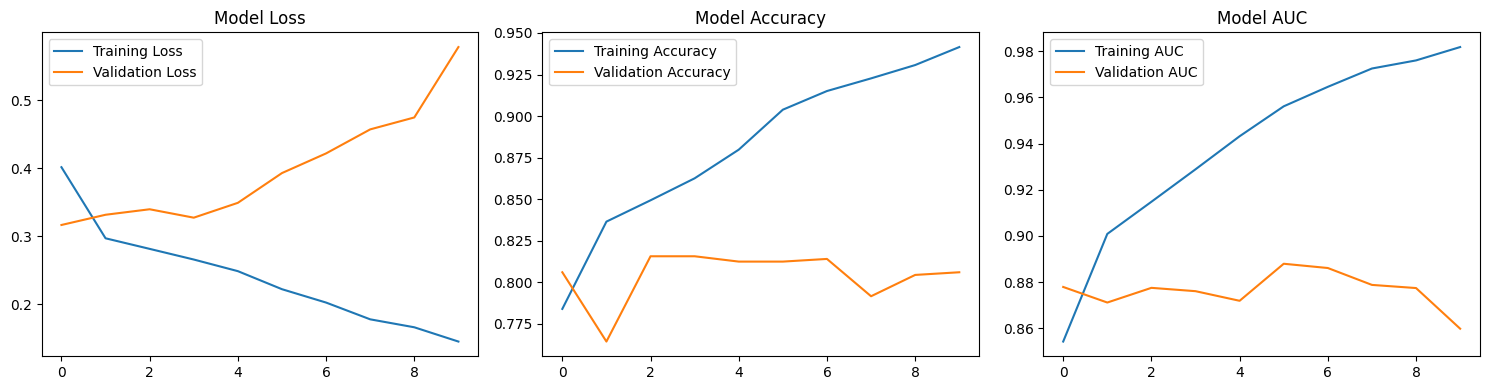

In [32]:
# Визуализация истории обучения для лучшей модели
def plot_training_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.legend()
    
    # Accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.legend()
    
    # AUC
    ax3.plot(history.history['auc'], label='Training AUC')
    ax3.plot(history.history['val_auc'], label='Validation AUC')
    ax3.set_title('Model AUC')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# Построение графиков для последней модели
plot_training_history(history)